In [1]:
import numpy as np 
import math

import torch 
from torch import nn
from torch.autograd import Variable 
from torch import Tensor as t
import torch.nn.functional as F
from torch.distributions import Normal
from torch.optim import Adam 

import ipympl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
#%matplotlib inline 
%matplotlib notebook

### import refactored code

In [2]:
%run utils.py
%run net.py
%run vi_lie.py

#### Loss Functions

In [61]:
def loss_func(v, xo_mb, y_mb, z_rot):
    """ Different loss functions
    Args:
        v = {spherical, l2, r_metrirc, log_r_metric}
    Returns:
        L: loss function of choice
    """
    
    xrot_mb = n2p(xo_mb @ y_mb)
    xrot_recon_mb = n2p(xo_mb) @ z_rot
    
    if v=='geodesic':
        L = ((xrot_recon_mb * xrot_mb).sum(-1) * 0.999).acos().sum(-1).mean()
    elif v=='l2':
        L = ((xrot_recon_mb - xrot_mb)**2).sum(-1).sum(-1).mean()
    elif v=='r_metric':
        I = Variable(torch.eye(3))
        L = ((I - n2p(y_mb)@z_rot.transpose(2,1))**2).sum(-1).sum(-1).mean()
    elif v=='log_r_metric':
        I = Variable(torch.eye(3))
        L = ((n2p(y_mb)@z_rot.transpose(2,1)))
        print (L)
        L = torch.log(L) * I
        print (L)
        lol()
        L = L.sum(-1).sum(-1).mean()
    else:
        return None
    
    return L

### Initialize Net

In [62]:
hidden_units = 128
N = Net(hidden_units)
optimizer = Adam(N.parameters())

### Train Net

In [ ]:
batch_size = 64
num_steps = 5000
loss_plot = []
random_m = False
var_noise = True

for i in range(num_steps):
    optimizer.zero_grad()
    xo_mb, xrot_mb, y_mb = next_batch(batch_size)
    x_mb = np.hstack((xo_mb.reshape(-1, 5 * 3), xrot_mb.reshape(-1, 5 * 3)))
    
    mu, L, D = N(n2p(x_mb), random=random_m)
    
    if random_m:
        D = Variable(torch.Tensor(1,1))
        H = Variable(torch.Tensor(1,1))
        z_rot = L
    else:
        noise = Variable(Normal(t(np.zeros(3)), t(np.ones(3))).sample_n(batch_size))    
        v = (L @ (D.pow(0.5)*noise)[..., None]).squeeze()

        H = -log_density(v, L, D, k = 10)

        mu_lie = rodrigues(mu)
        v_lie = rodrigues(v)
        g_lie = mu_lie
        if var_noise:
            g_lie = g_lie @ v_lie
        z_rot = g_lie
    
    L_rec = loss_func('geodesic', xo_mb, y_mb, z_rot)
    
    # weighting the entropy term to not be too strong
    kl_w = 5e-2
    L = L_rec - torch.mean(H)*kl_w
    L.backward()
    optimizer.step()
    print ('\r (%d/%d) L: %.3f \t D: %.3f \t H: %.3f' % 
           (i, num_steps, L_rec.data.numpy(), np.mean(D.data.numpy()), torch.mean(H)), end='')
    loss_plot.append(L_rec.data.numpy())


 (4105/5000) L: 0.906 	 D: 0.003 	 H: -4.272

### Some 3D plot

<IPython.core.display.Javascript object>


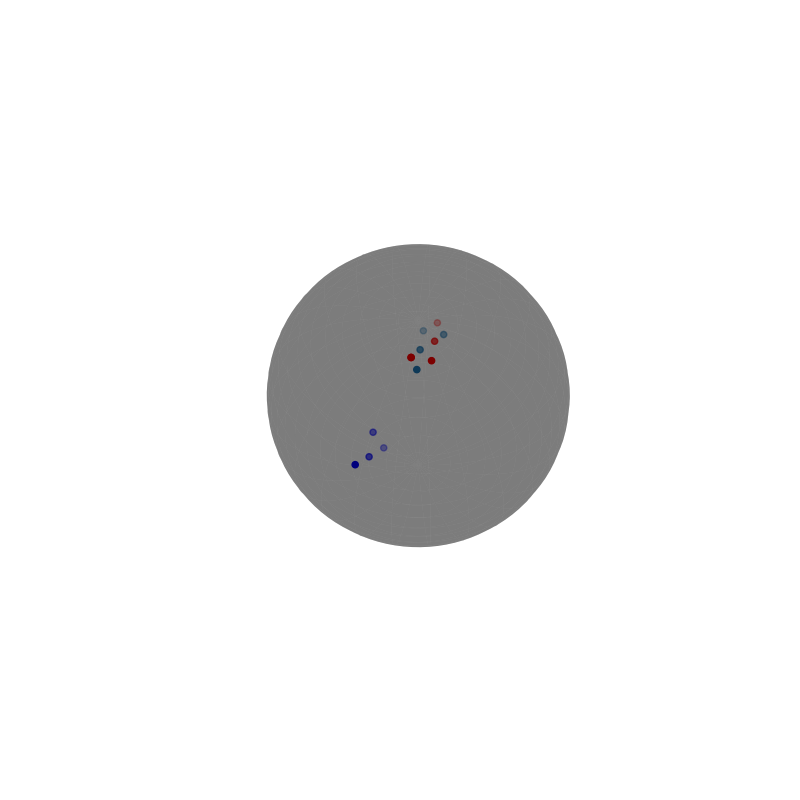

In [35]:
def plot_sphere(ax):
    u = np.linspace(0, 2 * np.pi, 100)
    v = np.linspace(0, np.pi, 100)

    x = 1 * np.outer(np.cos(u), np.sin(v))
    y = 1 * np.outer(np.sin(u), np.sin(v))
    z = 1 * np.outer(np.ones(np.size(u)), np.cos(v))

    ax.plot_surface(x, y, z,  rstride=4, cstride=4, color='#000000', linewidth=0, alpha=0.3)
    
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
ax.set_aspect('equal')

# get an input and rotation
xo, xrot, y = next_batch(1)
x_mb = np.hstack((xo.reshape(-1, 5 * 3), xrot.reshape(-1, 5 * 3)))
# plot the original and rotation
xs, ys, zs = xo.reshape(-1, 3).T
ax.scatter(xs, ys, zs, c='b')
xs, ys, zs = xrot.reshape(-1, 3).T
ax.scatter(xs, ys, zs, c='r')

# get samples from neural net
n_samples = 1
samples = xrot

for _ in range(n_samples):
    xrot_recon = get_sample(N, x_mb, xo, var_noise=var_noise)
    xs, ys, zs = xrot_recon.reshape(-1, 3).T
    ax.scatter(xs, ys, zs)
    samples = np.hstack((samples, xrot_recon))

plot_sphere(ax)
    
ax.grid(False)
plt.axis('off')
plt.show()